# Assignment 2

Before working on this assignment please read these instructions fully. In the submission area, you will notice that you can click the link to **Preview the Grading** for each step of the assignment. This is the criteria that will be used for peer grading. Please familiarize yourself with the criteria before beginning the assignment.

An NOAA dataset has been stored in the file `data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv`. The data for this assignment comes from a subset of The National Centers for Environmental Information (NCEI) [Daily Global Historical Climatology Network](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt) (GHCN-Daily). The GHCN-Daily is comprised of daily climate records from thousands of land surface stations across the globe.

Each row in the assignment datafile corresponds to a single observation.

The following variables are provided to you:

* **id** : station identification code
* **date** : date in YYYY-MM-DD format (e.g. 2012-01-24 = January 24, 2012)
* **element** : indicator of element type
    * TMAX : Maximum temperature (tenths of degrees C)
    * TMIN : Minimum temperature (tenths of degrees C)
* **value** : data value for element (tenths of degrees C)

For this assignment, you must:

1. Read the documentation and familiarize yourself with the dataset, then write some python code which returns a line graph of the record high and record low temperatures by day of the year over the period 2005-2014. The area between the record high and record low temperatures for each day should be shaded.
2. Overlay a scatter of the 2015 data for any points (highs and lows) for which the ten year record (2005-2014) record high or record low was broken in 2015.
3. Watch out for leap days (i.e. February 29th), it is reasonable to remove these points from the dataset for the purpose of this visualization.
4. Make the visual nice! Leverage principles from the first module in this course when developing your solution. Consider issues such as legends, labels, and chart junk.

The data you have been given is near **Toronto, Ontario, Canada**, and the stations the data comes from are shown on the map below.

In [1]:
import matplotlib.pyplot as plt
import mplleaflet
import pandas as pd
from tabulate import tabulate

def leaflet_plot_stations(binsize, hashid):

    df = pd.read_csv('data/C2A2_data/BinSize_d{}.csv'.format(binsize))

    station_locations_by_hash = df[df['hash'] == hashid]

    lons = station_locations_by_hash['LONGITUDE'].tolist()
    lats = station_locations_by_hash['LATITUDE'].tolist()

    plt.figure(figsize=(8,8))

    plt.scatter(lons, lats, c='r', alpha=0.7, s=200)

    return mplleaflet.display()

# leaflet_plot_stations(400,'fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89')

# Load and clean data
This section of code loads the data from the file and formats it. Part of the processing includes finding the minimum and maximum temperatures for a 10-year period, multi-indexing the data series with month and day. The 2015 temperatures are extracted from the data and any temperatures below the minimum or above the maximum for a given day is recorded.

In [59]:
# Load data
binsize = 400
hashid = 'fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89'
df = pd.read_csv(f'data/C2A2_data/BinnedCsvs_d{binsize}/{hashid}.csv')

# Format date to datetime
df['Date'] = pd.to_datetime(df['Date'], yearfirst = True, format='%Y-%m-%d').dt.normalize()

# Note that Data_Value are in tenth of a degree
# Multiple TMIN/TMAX because of the multiple ID per date
# Get the max(TMAX) and min(TMIN) for each date

# Extract 2005-2014 time period
# Determine the minimum and maximum temperatures for each day of the year
# (ignoring leap years). re-index the dataset by month -> day and find the
# min/max temperatures for the 10-year period.
# Convert the temperatures from tenths of a degree to degree.
# Note: dt.strftime('%b') to go from e.g. 01 -> Jan, '%B' for January
df_minmax = (df.loc[((df['Date'].dt.year >= 2005) &
                    (df['Date'].dt.year < 2015)) &
                    ~((df['Date'].dt.month == 2) & (df['Date'].dt.day == 29))] # Drop any leap year
             .pivot_table(index=[df['Date'].dt.month,df['Date'].dt.day],
                          columns='Element', values='Data_Value', aggfunc=(min, max)))
df_minmax = df_minmax.loc[:,[('max','TMAX'), ('min','TMIN')]]
df_minmax.columns = df_minmax.columns.droplevel(1) # remove TMIN/TMAX level
df_minmax /= 10 # Convert to degrees
df_minmax.index.names = ['Month','Day']
df_minmax['Year'] = 2015
df_minmax.reset_index(inplace=True)
df_minmax['Date'] = pd.to_datetime(df_minmax[['Year', 'Month','Day']]).dt.date
df_minmax = df_minmax[['Date','min','max']]



# Extract 2015 data and clean data
df_2015 = (df.loc[df['Date'].dt.year == 2015]
           .pivot_table(index=[df['Date'].dt.month,df['Date'].dt.day],
                        columns='Element', values='Data_Value', aggfunc=(max,min)))
df_2015 = df_2015.loc[:,[('max','TMAX'), ('min','TMIN')]]
df_2015.columns = df_2015.columns.droplevel(1) # remove TMIN/TMAX level
df_2015 /= 10 # Convert to degrees
df_2015.index.names = ['Month','Day']
df_2015['Year'] = 2015
df_2015.reset_index(inplace=True)
df_2015['Date'] = pd.to_datetime(df_2015[['Year', 'Month','Day']]).dt.date
df_2015 = df_2015[['Date','min','max']]


record_mins = df_minmax.loc[df_2015['min'] < df_minmax['min'], 'min']
record_maxs = df_minmax.loc[df_2015['max'] > df_minmax['max'], 'max']

# Troubleshooting code
print(f'df_2015 data frame, shape={df_2015.shape}')
print (tabulate(df_2015.head(10), headers = 'keys', tablefmt = 'orgtbl'))
print('#### #### ####')
print(f'df_minmax data frame, shape={df_minmax.shape}')
print (tabulate(df_minmax.head(10), headers = 'keys', tablefmt = 'orgtbl'))

df_2015 data frame, shape=(365, 3)
|    | Date       |   min |   max |
|----+------------+-------+-------|
|  0 | 2015-01-01 | -13.3 |   1.1 |
|  1 | 2015-01-02 | -12.2 |   3.9 |
|  2 | 2015-01-03 |  -6.7 |   3.9 |
|  3 | 2015-01-04 |  -8.8 |   4.4 |
|  4 | 2015-01-05 | -15.5 |   2.8 |
|  5 | 2015-01-06 | -18.2 |   3.3 |
|  6 | 2015-01-07 | -18.2 |  -6.7 |
|  7 | 2015-01-08 | -21.1 |  -8.2 |
|  8 | 2015-01-09 | -20.6 |  -6.6 |
|  9 | 2015-01-10 | -20.6 |  -7.1 |
#### #### ####
df_minmax data frame, shape=(365, 3)
|    | Date       |   min |   max |
|----+------------+-------+-------|
|  0 | 2015-01-01 | -16   |  15.6 |
|  1 | 2015-01-02 | -26.7 |  13.9 |
|  2 | 2015-01-03 | -26.7 |  13.3 |
|  3 | 2015-01-04 | -26.1 |  10.6 |
|  4 | 2015-01-05 | -15   |  12.8 |
|  5 | 2015-01-06 | -26.6 |  18.9 |
|  6 | 2015-01-07 | -30.6 |  21.7 |
|  7 | 2015-01-08 | -29.4 |  19.4 |
|  8 | 2015-01-09 | -27.8 |  17.8 |
|  9 | 2015-01-10 | -25.6 |  10   |


# Plot Data
The code below plots the daily maximum and minimum temperatures for the 2005--2014 time period. Any days in 2015 where the minimum daily temperature is below the 10-year minimum or the maximum daily temperature is above the 10-year maximum is shown as a point.

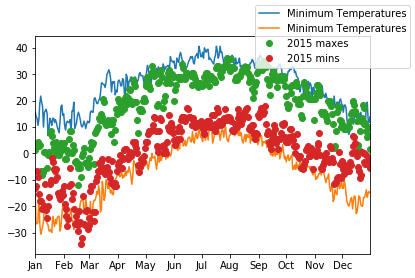

In [58]:
from matplotlib.dates import MonthLocator, DateFormatter

fig, ax = plt.subplots()
ax.plot(df_minmax['Date'], df_minmax['max'], label='Minimum Temperatures')
ax.plot(df_minmax['Date'], df_minmax['min'], label='Minimum Temperatures')
ax.plot(df_2015['Date'], df_2015['max'], 'o', label='2015 maxes')
ax.plot(df_2015['Date'], df_2015['min'], 'o', label='2015 mins')

ax.set_xlim(df_minmax['Date'].iloc[0], df_minmax['Date'].iloc[-1])
ax.xaxis.set_major_locator(MonthLocator())
ax.xaxis.set_major_formatter(DateFormatter('%b'))

fig.legend()

plt.show()